In [1]:
#need to make a table that has the top 33% of movies by popularity, with ratings over 7.0, and actors/actresses in the cast
#need to include the actor/actress name, movie name, rating, profit, and popularity
#adjust as needed
cte_mega_string = """
WITH FilteredRatings AS (
    SELECT tconst, averageRating, numVotes
    FROM dbo.ratings
    WHERE averageRating > 7.0
),
FilteredPopularity AS (
    Select
        imdb_id,
        popularity,
        -- 1 = top 33%, 2 = middle 33%, 3 = bottom 33%
        NTILE(3) OVER (ORDER BY popularity DESC) AS popularity_percentile 
    from dbo.meta
),FilteredBasics AS (
    SELECT tconst, primaryTitle, startYear
    FROM dbo.basics
    WHERE startYear >= 2000
), -- calculate profit not always available
CalculatedProfit AS (
    SELECT imdb_id, (revenue - budget) AS profit
    FROM dbo.meta
)
SELECT
    cast.tconst, -- movie number unique id
    base.primaryTitle, --movie name
    cast.category,
    rates.averageRating, -- ratings
    nam.primaryName AS actor_name,
    CalculatedProfit.profit,
    pop.popularity
FROM dbo.principals AS cast
JOIN FilteredBasics AS base ON base.tconst = cast.tconst
JOIN FilteredRatings AS rates ON rates.tconst = cast.tconst
JOIN CalculatedProfit on CalculatedProfit.imdb_id = cast.tconst
JOIN dbo.name AS nam ON nam.nconst = cast.nconst
JOIN FilteredPopularity AS pop ON pop.imdb_id = cast.tconst
WHERE cast.category IN ('actor', 'actress')
    AND pop.popularity_percentile = 1
ORDER BY pop.popularity DESC;
"""


In [2]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
# connection details
server = 'sourcetoshare.database.windows.net'
database = 'imdb'
username = 'jeffrey'
password = 'JAw1BcMunBB7JGgKoWDNRwnUvNxDvW5yUClzwlomuIY8='
driver = 'ODBC Driver 17 for SQL Server'


# Create the connection string in SQLAlchemy format
conn_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver.replace(" ", "+")}'

# Create the SQLAlchemy engine
engine = create_engine(conn_string)
# Execute the query and load the data into a pandas DataFrame
cte_df = pd.read_sql(cte_mega_string, conn_string)

# Display the first few rows of the dataframe
print(cte_df.head())

      tconst     primaryTitle category  averageRating      actor_name  \
0  tt0468569  The Dark Knight    actor            9.0  Morgan Freeman   
1  tt0468569  The Dark Knight    actor            9.0     Gary Oldman   
2  tt0468569  The Dark Knight    actor            9.0  Christian Bale   
3  tt0468569  The Dark Knight    actor            9.0  Christian Bale   
4  tt0468569  The Dark Knight    actor            9.0   Michael Caine   

      profit  popularity  
0  819558444  123.167259  
1  819558444  123.167259  
2  819558444  123.167259  
3  819558444  123.167259  
4  819558444  123.167259  


In [3]:
# first we need to clean up the data
# 1. remove empties
cte_df = cte_df.dropna()
#Creates a new binary column for each unique actor name. 
cte_df = pd.get_dummies(cte_df, columns=['actor_name'])
cte_df.head(n=5)


,tconst,primaryTitle,category,averageRating,profit,popularity,actor_name_Aamir Khan,actor_name_Aankha Neal,actor_name_Aaron Eckhart,actor_name_Aaron Murphy,...,actor_name_Zsolt Nagy,actor_name_Zuhal Gencer,actor_name_Zuleikha Robinson,actor_name_Álex Angulo,actor_name_Álvaro Guerrero,actor_name_Élodie Navarre,actor_name_Émile Vallée,actor_name_Éva Darlan,actor_name_Özge Özberk,actor_name_Özkan Ugur
0,tt0468569,The Dark Knight,actor,9.0,819558444,123.167259,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0468569,The Dark Knight,actor,9.0,819558444,123.167259,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0468569,The Dark Knight,actor,9.0,819558444,123.167259,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tt0468569,The Dark Knight,actor,9.0,819558444,123.167259,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,tt0468569,The Dark Knight,actor,9.0,819558444,123.167259,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# We'll start easy by just using the profit and popularity columns
correlation = cte_df[['profit', 'popularity']].corr()
print(correlation)

             profit  popularity
profit      1.00000     0.64804
popularity  0.64804     1.00000


In [5]:
# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
#since there are a ton of names we'll use a loop to create a bunch of columns
selected_columns = ['popularity'] + [col for col in cte_df.columns if col.startswith('actor_')]
print(selected_columns)

['popularity', 'actor_name_Aamir Khan', 'actor_name_Aankha Neal', 'actor_name_Aaron Eckhart', 'actor_name_Aaron Murphy', 'actor_name_Aaron Taylor-Johnson', 'actor_name_Abby Mukiibi Nkaaga', 'actor_name_Abdol Rahman Karim', 'actor_name_Abigail Breslin', 'actor_name_Adam Baldwin', 'actor_name_Adam Goldberg', 'actor_name_Adam Kaufman', 'actor_name_Adam Kotz', 'actor_name_Adam LeFevre', 'actor_name_Ade', 'actor_name_Adewale Akinnuoye-Agbaje', 'actor_name_Adil Hussain', 'actor_name_Adrian Alonso', 'actor_name_Adrian Rawlins', 'actor_name_Adriana Asti', 'actor_name_Adriano Giannini', 'actor_name_Adrien Brody', 'actor_name_Ahmad Khan Mahmoodzada', 'actor_name_Ahmed Khan', 'actor_name_Ahmedov Ayder', 'actor_name_Ahn Kil-kang', 'actor_name_Ahn Nae-sang', 'actor_name_Aida Leiner', 'actor_name_Aiden Lithgow', 'actor_name_Ailing Xu', 'actor_name_Ailton Graça', 'actor_name_Aino-Maija Tikkanen', 'actor_name_Aishwarya Rai Bachchan', 'actor_name_Aitana Sánchez-Gijón', 'actor_name_Ajil Zibari', 'actor_

In [6]:
# Create a new dataframe with only the selected columns
new_df = cte_df[selected_columns]

# Calculate the correlation matrix
pop_matrix = new_df.corr()

# remove the 100 correlation with itself
pop_matrix = pop_matrix.drop('popularity')

# Remove the 'actor_' prefix from the index
pop_matrix.index = pop_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
pop_matrix= pop_matrix['popularity'].sort_values(ascending=False)

print(pop_matrix)

Monique Gabriela Curnen    0.205554
Ron Dean                   0.205554
Christian Bale             0.187308
Maggie Gyllenhaal          0.155185
Heath Ledger               0.146762
                             ...   
Terrence 'T.C.' Carson    -0.023496
Boman Irani               -0.023730
Cem Yilmaz                -0.025236
Phil LaMarr               -0.028679
John DiMaggio             -0.036440
Name: popularity, Length: 2600, dtype: float64


# Correlation results for popularity and actors
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the popularity of the movie.

In [7]:
# Now we'll use all the actor columns and the profit column, since we're interested in the relationship between the actors and the profit of the movie
selected_columns = ['profit'] + [col for col in cte_df.columns if col.startswith('actor_')]

# Create a new dataframe with only the selected columns
new_df = cte_df[selected_columns]

# Calculate the correlation matrix
profit_matrix = new_df.corr()

# remove the 100 correlation with itself
profit_matrix = profit_matrix.drop('profit')


# Remove the 'actor_' prefix from the index
profit_matrix = profit_matrix['profit'].sort_values(ascending=False)
profit_matrix.index = profit_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
print(profit_matrix)

Emma Watson           0.141520
Rupert Grint          0.141520
Daniel Radcliffe      0.141520
Sala Baker            0.136110
Orlando Bloom         0.135302
                        ...   
Meryl Streep         -0.026073
John DiMaggio        -0.026430
Martin McCann        -0.028098
Toby Leonard Moore   -0.028098
Joseph Mazzello      -0.034418
Name: profit, Length: 2600, dtype: float64


# Correlation result for profit and actors:
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the profit of the movie.

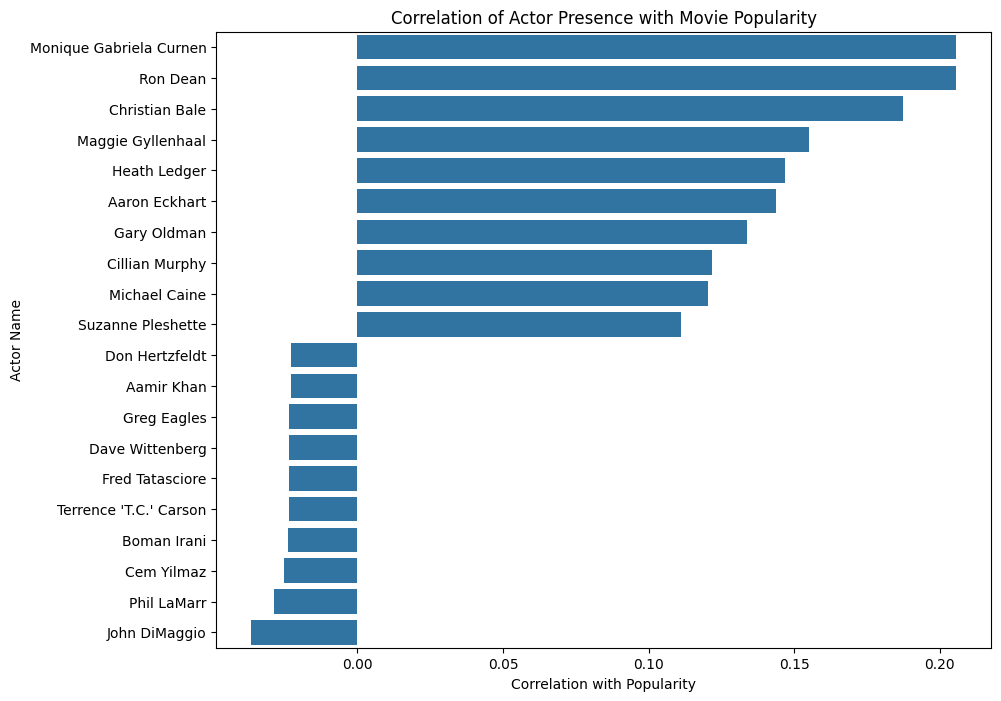

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrixa Keep only the top 10 and bottom 10 correlations
top_10 = pop_matrix.head(10)
bottom_10 = pop_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Popularity')
plt.ylabel('Actor Name')
plt.title('Correlation of Actor Presence with Movie Popularity')
plt.show()

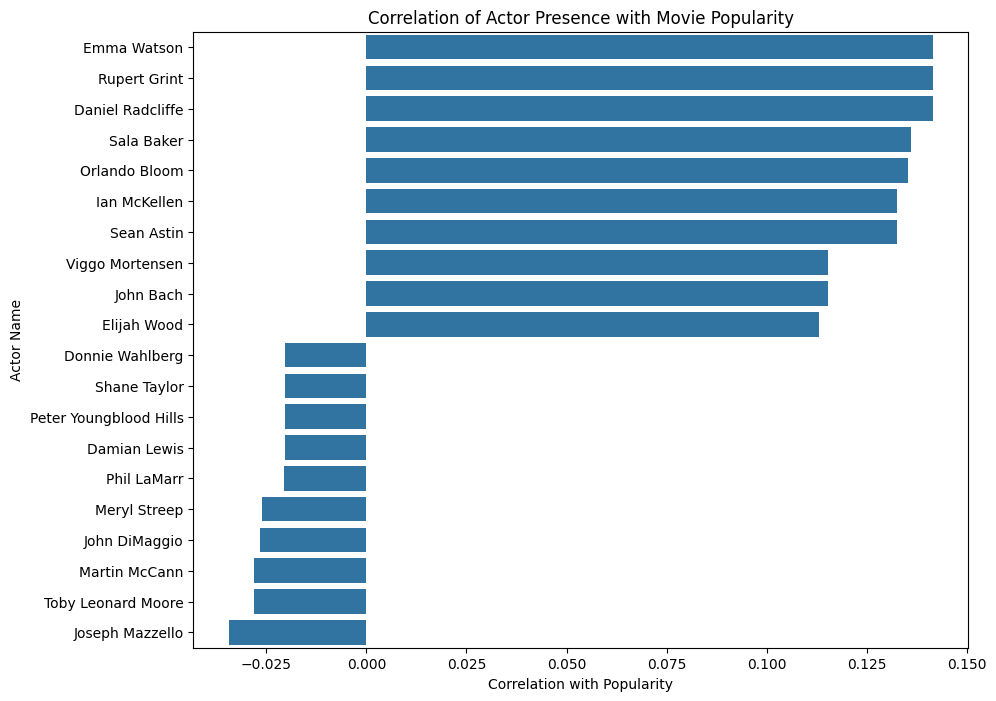

In [ ]:

# Calculate the correlation  Keep only the top 10 and bottom 10 correlations
top_10 = profit_matrix.head(10)
bottom_10 = profit_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Popularity')
plt.ylabel('Actor Name')
plt.title('Correlation of Actor Presence with Movie profit')
plt.show()